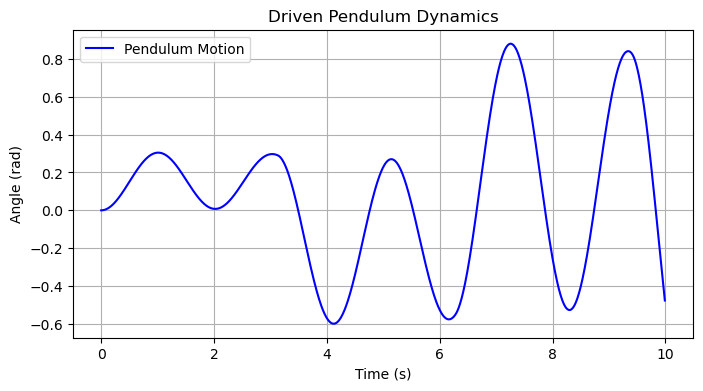

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

## Simulating the Pendulum

# Parameters
g = 9.81  # Gravity (m/s^2)
l = 1.0   # Length of pendulum (m)
k = 0.05  # Damping coefficient
f_min, f_max = 1.0, 2.0  # Range for force amplitude encoding
omega_fixed = 1.0  # Fixed frequency for amplitude encoding
dt = 0.01  # Time step
T = 10  # Total time

def pendulum_dynamics(t, state, f, omega):
    """ Defines the pendulum equation of motion with forcing. """
    x, v = state  # Position and velocity
    dxdt = v
    dvdt = -g/l * np.sin(x) - k * v + f * np.sign(np.sin(omega * t))
    return [dxdt, dvdt]

def simulate_pendulum(f, omega, init_state=[0, 0], duration=T, dt=dt):
    """ Simulates the pendulum dynamics for given forcing parameters. """
    t_span = (0, duration)
    t_eval = np.arange(0, duration, dt)
    sol = solve_ivp(pendulum_dynamics, t_span, init_state, t_eval=t_eval, args=(f, omega))
    return sol.t, sol.y[0]  # Return time array and position

# Example Simulation
t, x = simulate_pendulum(f=1.5, omega=1.0)
plt.figure(figsize=(8, 4))
plt.plot(t, x, label="Pendulum Motion", color="blue")
plt.xlabel("Time (s)")
plt.ylabel("Angle (rad)")
plt.title("Driven Pendulum Dynamics")
plt.legend()
plt.grid()
plt.show()


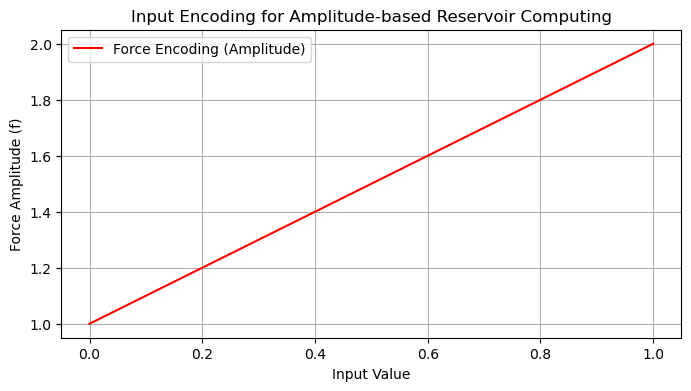

In [2]:

# Input Encoding Visualization

def encode_input(inputs, encoding_type="amplitude"):
    """ Maps input values to pendulum forcing parameters. """
    if encoding_type == "amplitude":
        return f_min + (f_max - f_min) * inputs, omega_fixed
    elif encoding_type == "frequency":
        f_fixed = 1.5  # Fixed amplitude
        omega_min, omega_max = 0.5, 1.5  # Frequency range
        return f_fixed, omega_min + (omega_max - omega_min) * inputs
    else:
        raise ValueError("Invalid encoding type")

# Plot Encoding
inputs = np.linspace(0, 1, 100)
f_encoded, omega_encoded = encode_input(inputs, encoding_type="amplitude")

plt.figure(figsize=(8, 4))
plt.plot(inputs, f_encoded, label="Force Encoding (Amplitude)", color="red")
plt.xlabel("Input Value")
plt.ylabel("Force Amplitude (f)")
plt.title("Input Encoding for Amplitude-based Reservoir Computing")
plt.legend()
plt.grid()
plt.show()


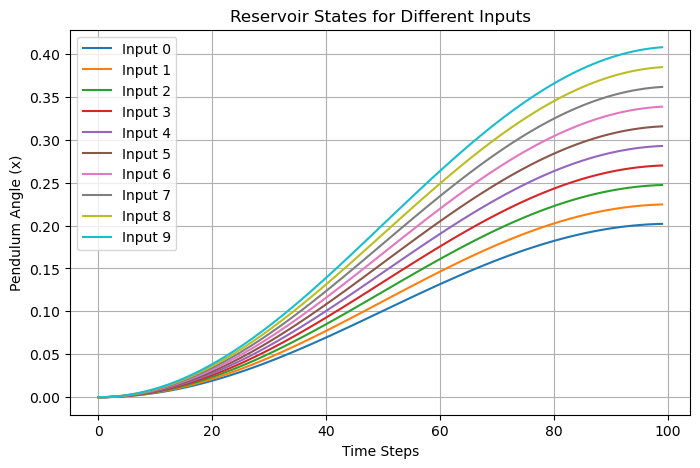

In [3]:

# Feature Extraction - Reservoir State Visualization


def generate_reservoir_states(inputs, encoding_type="amplitude", samples_per_input=100):
    """ Runs the pendulum for each input and collects transient dynamics. """
    reservoir_states = []
    for inp in inputs:
        f, omega = encode_input(inp, encoding_type)
        t, x = simulate_pendulum(f, omega)
        sampled_x = x[:samples_per_input]  # Take a fixed number of samples
        reservoir_states.append(sampled_x)
    return np.array(reservoir_states)

# Generate Reservoir States
num_samples = 10
test_inputs = np.linspace(0, 1, num_samples)
reservoir_states = generate_reservoir_states(test_inputs, encoding_type="amplitude")

plt.figure(figsize=(8, 5))
for i in range(num_samples):
    plt.plot(reservoir_states[i], label=f"Input {i}")
plt.xlabel("Time Steps")
plt.ylabel("Pendulum Angle (x)")
plt.title("Reservoir States for Different Inputs")
plt.legend()
plt.grid()
plt.show()


Epoch [0/1000], Loss: 0.002215
Epoch [10/1000], Loss: 0.001495
Epoch [20/1000], Loss: 0.000956
Epoch [30/1000], Loss: 0.000541
Epoch [40/1000], Loss: 0.000367
Epoch [50/1000], Loss: 0.000357
Epoch [60/1000], Loss: 0.000360
Epoch [70/1000], Loss: 0.000350
Epoch [80/1000], Loss: 0.000348
Epoch [90/1000], Loss: 0.000346
Epoch [100/1000], Loss: 0.000343
Epoch [110/1000], Loss: 0.000340
Epoch [120/1000], Loss: 0.000337
Epoch [130/1000], Loss: 0.000334
Epoch [140/1000], Loss: 0.000332
Epoch [150/1000], Loss: 0.000327
Epoch [160/1000], Loss: 0.000324
Epoch [170/1000], Loss: 0.000320
Epoch [180/1000], Loss: 0.000317
Epoch [190/1000], Loss: 0.000313
Epoch [200/1000], Loss: 0.000310
Epoch [210/1000], Loss: 0.000306
Epoch [220/1000], Loss: 0.000324
Epoch [230/1000], Loss: 0.000305
Epoch [240/1000], Loss: 0.000300
Epoch [250/1000], Loss: 0.000294
Epoch [260/1000], Loss: 0.000290
Epoch [270/1000], Loss: 0.000287
Epoch [280/1000], Loss: 0.000283
Epoch [290/1000], Loss: 0.000280
Epoch [300/1000], Los

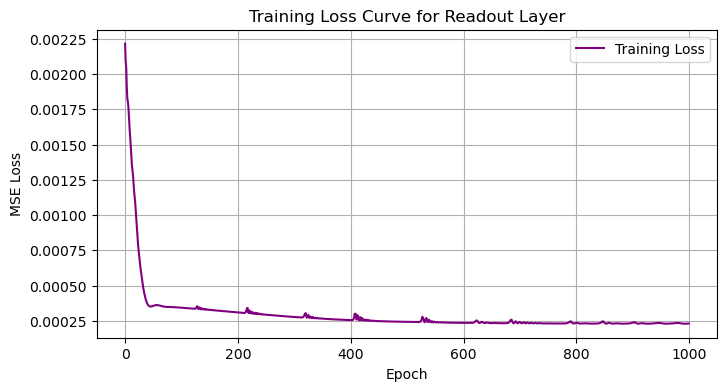

In [10]:
# PyTorch Training (Linear Regression for Readout)

class ReadoutLayer(nn.Module):
    """ Simple feedforward neural network for reservoir computing. """
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ReadoutLayer, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Generating dataset
num_samples = 5000
input_values = np.random.rand(num_samples)  # Random inputs in [0, 1]
target_values = (input_values - 0.5) ** 3  # Some nonlinear function
reservoir_states = generate_reservoir_states(input_values, encoding_type="amplitude")

# Convert to PyTorch tensors
X_train = torch.tensor(reservoir_states, dtype=torch.float32)
y_train = torch.tensor(target_values, dtype=torch.float32).unsqueeze(1)

# Model
input_dim = X_train.shape[1]
hidden_dim = 64
output_dim = 1
model = ReadoutLayer(input_dim, hidden_dim, output_dim)

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 1000
loss_history = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())

    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}")

# Plot Training Loss
plt.figure(figsize=(8, 4))
plt.plot(loss_history, label="Training Loss", color="purple")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curve for Readout Layer")
plt.legend()
plt.grid()
plt.show()


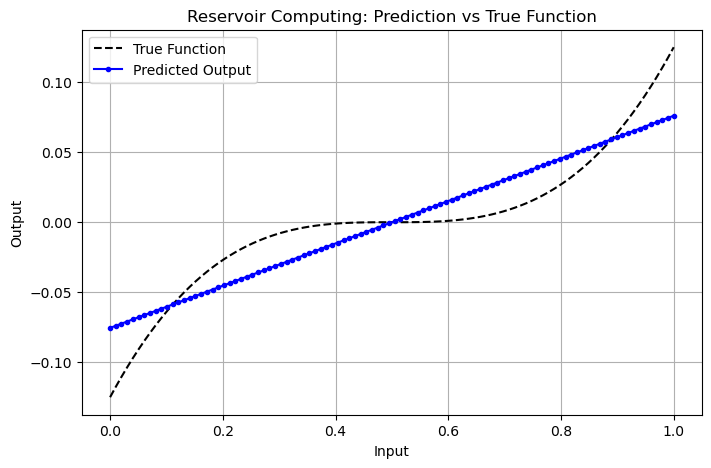

In [9]:

# Testing and Visualization

# Generate test data
test_inputs = np.linspace(0, 1, 100)
test_targets = (test_inputs - 0.5) ** 3
test_reservoir_states = generate_reservoir_states(test_inputs, encoding_type="amplitude")
X_test = torch.tensor(test_reservoir_states, dtype=torch.float32)

# Prediction
with torch.no_grad():
    predictions = model(X_test).squeeze().numpy()

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(test_inputs, test_targets, label="True Function", linestyle="dashed", color="black")
plt.plot(test_inputs, predictions, label="Predicted Output", marker="o", markersize=3, color="blue")
plt.xlabel("Input")
plt.ylabel("Output")
plt.title("Reservoir Computing: Prediction vs True Function")
plt.legend()
plt.grid()
plt.show()


In [18]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define pendulum dynamics
def pendulum_dynamics(t, state, g=9.81, l=1.0, k=0.05, f=1.5, omega=1.0):
    x, v = state
    dxdt = v
    dvdt = - (g / l) * np.sin(x) - k * v + f * np.sign(np.sin(omega * t))
    return [dxdt, dvdt]

# Generate dataset
def generate_reservoir_data(f_values, omega, t_max=10, dt=0.01):
    time = np.arange(0, t_max, dt)
    reservoir_states = []
    
    for f in f_values:
        sol = solve_ivp(pendulum_dynamics, [0, t_max], [0, 0], t_eval=time, args=(9.81, 1.0, 0.05, f, omega))
        reservoir_states.append(sol.y[0])  # Use x(t) as state
    
    return np.array(reservoir_states), time

# Generate input-output pairs
def generate_task_data(num_samples=500):
    x_values = np.linspace(-3, 3, num_samples)
    y_values = np.prod([(x_values - i) for i in range(-3, 4)], axis=0)  # Seventh-degree polynomial
    return x_values, y_values

# Define readout layer
class ReadoutLayer(nn.Module):
    def __init__(self, input_dim):
        super(ReadoutLayer, self).__init__()
        self.fc = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return self.fc(x)

# Train the readout layer
def train_readout(X_train, y_train, epochs=100000, lr=0.01):
    model = ReadoutLayer(X_train.shape[1])
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = model(torch.tensor(X_train, dtype=torch.float32))
        loss = criterion(y_pred, torch.tensor(y_train, dtype=torch.float32).view(-1, 1))
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    
    return model

# Generate training data
f_values = np.linspace(1, 2, 5000)
X_reservoir, time = generate_reservoir_data(f_values, omega=1.0)
X_train, y_train = generate_task_data(num_samples=5000)

# # Train model
# model = train_readout(X_reservoir, y_train)

# # Predict
# y_pred = model(torch.tensor(X_reservoir, dtype=torch.float32)).detach().numpy()

# # Plot results
# plt.figure(figsize=(8,5))
# plt.plot(X_train, y_train, label='True Function')
# plt.scatter(X_train, y_pred, label='Predicted', color='red', s=5)
# plt.legend()
# plt.show()


Epoch 0, Loss: 1522.1153564453125
Epoch 100, Loss: 943.11279296875
Epoch 200, Loss: 942.1383056640625
Epoch 300, Loss: 940.9069213867188
Epoch 400, Loss: 939.4376831054688
Epoch 500, Loss: 937.76220703125
Epoch 600, Loss: 935.9027709960938
Epoch 700, Loss: 933.8770751953125
Epoch 800, Loss: 931.7000732421875
Epoch 900, Loss: 929.385009765625
Epoch 1000, Loss: 926.943603515625
Epoch 1100, Loss: 924.3870239257812
Epoch 1200, Loss: 921.7261962890625
Epoch 1300, Loss: 918.9710083007812
Epoch 1400, Loss: 916.1314086914062
Epoch 1500, Loss: 913.2169189453125
Epoch 1600, Loss: 910.23681640625
Epoch 1700, Loss: 907.2003173828125
Epoch 1800, Loss: 904.2918090820312
Epoch 1900, Loss: 901.1744995117188
Epoch 2000, Loss: 898.1873168945312
Epoch 2100, Loss: 895.2252807617188
Epoch 2200, Loss: 892.3607177734375
Epoch 2300, Loss: 889.4713134765625
Epoch 2400, Loss: 886.636474609375
Epoch 2500, Loss: 883.8826904296875
Epoch 2600, Loss: 881.1192016601562
Epoch 2700, Loss: 878.3978881835938
Epoch 2800, 

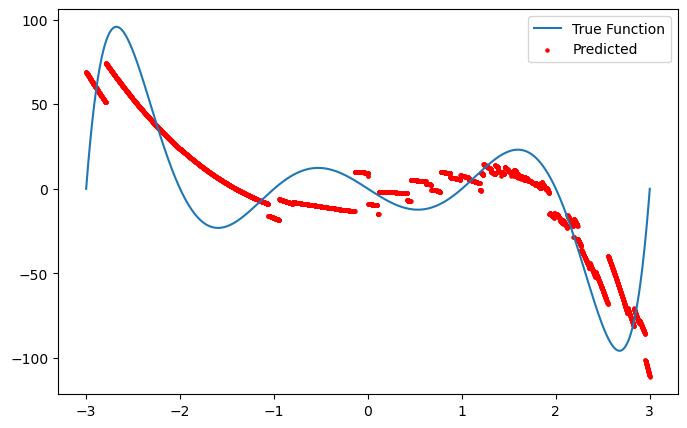

In [19]:

# Train model
model = train_readout(X_reservoir, y_train, epochs=100000, lr=0.02)

# Predict
y_pred = model(torch.tensor(X_reservoir, dtype=torch.float32)).detach().numpy()

# Plot results
plt.figure(figsize=(8,5))
plt.plot(X_train, y_train, label='True Function')
plt.scatter(X_train, y_pred, label='Predicted', color='red', s=5)
plt.legend()
plt.show()